In [1]:
### File Organization ###
# Imports
# Data Prep Helper methods and variables
# Graph Plotting methods
# Data Prep - Pulling data from Fastquant
# Data Prep - Creating factional data sets
# RNN Models
    # Simple RNN
    # Groovy (5 layer GRU model)
    # Loovy (5 layer LSTM model)
    # Super Groovy (8 layer GRU model)
    # Super Loovy (8 layer LSTM model)
# Train/Predict methods
# Training/Testing Models
    # Simple RNN - High column only

In [2]:
from fastquant import get_stock_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout

Using TensorFlow backend.


In [3]:
# Data Prep - Helper Methods/Vars

train_range = 60 # length of days to split data on

# Extract factional change, fractional high, and fractional low
# No normalization/standardization
def frac_data_prep(data, y_key='close'):
    x = pd.DataFrame(data=None, columns=['fracChange','fracHigh','fracLow'])
    x['fracChange'] = (data['close']-data['open'])/data['open']
    x['fracHigh'] = (data['high']-data['open'])/data['open']
    x['fracLow'] = (data['open']-data['low'])/data['open']

    # y = data[y_key].values

    return x

# Probably gonna trash
# def get_x_y_frac_sets(ticker):
#     if ticker == 'aapl':
#         return frac_x_apple_train.to_numpy(), frac_y_apple_train, frac_x_apple_test.to_numpy(), frac_y_apple_test
#     if ticker == 'ibm':
#         return frac_x_ibm_train.to_numpy(), frac_y_ibm_train, frac_x_ibm_test.to_numpy(), frac_y_ibm_test

# Extract high
# Normalize high Data
def high_data_prep(train_data, test_data, scaler):
    # df_train = pd.DataFrame(data=None, columns=['high'])
    # df_train['high'] = train_data['high']
    high_train_data = train_data['high'].values

    # df_test = pd.DataFrame(data=None, columns=['high'])
    # df_test['high'] = test_data['high']
    high_test_data = test_data['high'].values

    high_train_data = high_train_data.reshape(-1,1)
    high_test_data = high_test_data.reshape(-1,1)

    train_scale = scaler.fit_transform(high_train_data)
    test_scale = scaler.transform(high_test_data)

    return train_scale, test_scale, high_test_data, scaler

# Split train/test data into x/y sets
# For single column i.e. like high only
def get_x_y_sets(train_data, test_data):
    X_train = []
    Y_train = []

    for i in range(train_range, len(train_data)):
        # print(i)
        X_train.append(train_data[i-train_range:i, 0])
        # print()
        Y_train.append(train_data[i,0])
        # print()

    x_train, y_train = np.array(X_train), np.array(Y_train)

    x_train = np.reshape(x_train, (*x_train.shape, 1))

    X_test = []
    for i in range(train_range, len(test_data)):
        X_test.append(train_data[i-train_range:i,0])
    
    x_test = np.array(X_test)

    x_test = np.reshape(x_test, (*x_test.shape, 1))

    return x_train, y_train, x_test

In [4]:
# Plotting methods
def plot_results(preds, actual, title):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_title(title)
    time = range(len(preds))
    ax.plot(time,preds,color='tab:red',marker='s',markersize=2,linestyle='-',linewidth=1,label='forcast')
    ax.plot(time,actual,color='tab:blue',marker='s',markersize=2,linestyle='-',linewidth=1,label='actual')
    ax.set_xlabel('time')
    ax.set_ylabel('stock price ($)')
    ax.set_xticks(np.arange(0,len(preds)+10,10))
    ax.set_xlim(0,len(preds)+10)
    ax.xaxis.grid(True,ls='--')
    ax.yaxis.grid(True,ls='--')
    ax.legend()
    fig.tight_layout()
    plt.savefig(f'../imgs/{title}.png', ext='png', bbox_inches="tight")  

In [5]:
# Data Prep - Get Data

# training with apple feb-10-2003 -> sep-10-2004
full_apple_train = get_stock_data("AAPL","2003-02-10","2004-09-10")
# testing with apple sep-13-2004 -> jan-21-2005
full_apple_test =  get_stock_data("AAPL","2004-09-13","2005-01-21")
# training with IBM feb-10-2003 -> sep-10-2004
full_ibm_train = get_stock_data("IBM","2003-02-10","2004-09-10")
# testing with IBM sep-13-2004 -> jan-21-2005
full_ibm_test =  get_stock_data("IBM","2004-09-13","2005-01-21")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
# Data Prep - Build Train/Test Sets

# Prepare Fractional Change/High/Low Data
frac_apple_train = frac_data_prep(full_apple_train) #, frac_y_apple_train = frac_data_prep(full_apple_train)
frac_apple_test = frac_data_prep(full_apple_test) #, frac_y_apple_test = frac_data_prep(full_apple_test)
frac_ibm_train = frac_data_prep(full_ibm_train) #, frac_y_ibm_train = frac_data_prep(full_ibm_train)
frac_ibm_test = frac_data_prep(full_ibm_test) #, frac_y_ibm_test = frac_data_prep(full_ibm_test)

In [7]:
# Build SimpleRNN Model

# 3 SimpleRNN layers with 32 inputs. Returns full sequence.
# 1 SimpleRNN layer with 32 inputs. Does not return full sequence
# 1 Dense layer with 1 input. 
# input -> 32 -> 32 -> 32 -> 32noFS -> 1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

sr_learning_rate = 0.001
sr_momentum = 0.9
sr_optimizer = tf.keras.optimizers.RMSprop(learning_rate=sr_learning_rate,  momentum=sr_momentum)
sr_loss = 'mean_absolute_percentage_error'
sr_activation_funct = 'elu'
sr_epochs = 100
sr_batch_size = 150
sr_dropout = 0.2

# Builds a new instance of Simple RNN and scaler (if needed)
def build_simple_rnn(useDropout = True):
    # scaler = MinMaxScaler(feature_range=(0,1))
    scaler = StandardScaler()

    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True, activation=sr_activation_funct))
    if useDropout: model.add(Dropout(sr_dropout))
    model.add(SimpleRNN(32, return_sequences=True, activation=sr_activation_funct))
    if useDropout: model.add(Dropout(sr_dropout))
    model.add(SimpleRNN(32, return_sequences=True, activation=sr_activation_funct))
    if useDropout: model.add(Dropout(sr_dropout))
    model.add(SimpleRNN(32, return_sequences=False, activation=sr_activation_funct))
    model.add(Dense(1, activation=sr_activation_funct))

    model.compile(optimizer=sr_optimizer, loss=sr_loss)

    return model, scaler

In [8]:
# Build Groovy Model

# 3 GRU layers with 50 inputs. Returns full sequence
# 1 GRU layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
g_learning_rate = 0.001
g_momentum = 0.9
g_optimizer = tf.keras.optimizers.RMSprop(learning_rate=g_learning_rate,  momentum=g_momentum)
g_loss = 'mean_absolute_percentage_error'
g_activation_funct = 'elu'
g_epochs = 100
g_batch_size = 150
g_dropout = 0.2

def build_groovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(GRU(50, return_sequences=True, activation=g_activation_funct))
    if useDropout: model.add(Dropout(g_dropout))
    model.add(GRU(50, return_sequences=True, activation=g_activation_funct))
    if useDropout: model.add(Dropout(g_dropout))
    model.add(GRU(50, return_sequences=True, activation=g_activation_funct))
    if useDropout: model.add(Dropout(g_dropout))
    model.add(GRU(50, return_sequences=False, activation=g_activation_funct))
    model.add(Dense(1, activation=g_activation_funct))

    model.compile(optimizer=g_optimizer, loss=g_loss)

    return model, scaler

In [9]:
# Build Loovy Model

# 3 LSTM layers with 50 inputs. Returns full sequence
# 1 LSTM layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
l_learning_rate = 0.001
l_momentum = 0.9
l_optimizer = tf.keras.optimizers.RMSprop(learning_rate=l_learning_rate,  momentum=l_momentum)
l_loss = 'mean_absolute_percentage_error'
l_activation_funct = 'elu'
l_epochs = 100
l_batch_size = 150
l_dropout = 0.2

def build_loovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, activation=l_activation_funct))
    if useDropout: model.add(Dropout(l_dropout))
    model.add(LSTM(50, return_sequences=True, activation=l_activation_funct))
    if useDropout: model.add(Dropout(l_dropout))
    model.add(LSTM(50, return_sequences=True, activation=l_activation_funct))
    if useDropout: model.add(Dropout(l_dropout))
    model.add(LSTM(50, return_sequences=False, activation=l_activation_funct))
    model.add(Dense(1, activation=l_activation_funct))

    model.compile(optimizer=l_optimizer, loss=l_loss)

    return model, scaler

In [10]:
# Build SuperGroovy Model

# 6 GRU layers with 50 inputs. Returns full sequence
# 1 GRU layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
sg_learning_rate = 0.001
sg_momentum = 0.9
sg_optimizer = tf.keras.optimizers.RMSprop(learning_rate=sg_learning_rate,  momentum=sg_momentum)
sg_loss = 'mean_absolute_percentage_error'
sg_activation_funct = 'elu'
sg_epochs = 100
sg_batch_size = 150
sg_dropout = 0.2

def build_super_groovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=True, activation=sg_activation_funct))
    if useDropout: model.add(Dropout(sg_dropout))
    model.add(GRU(50, return_sequences=False, activation=sg_activation_funct))
    model.add(Dense(1, activation=sg_activation_funct))

    model.compile(optimizer=sg_optimizer, loss=sg_loss)

    return model, scaler

In [11]:
# Build SuperLoovy Model

# 6 LSTM layers with 50 inputs. Returns full sequence
# 1 LSTM layer with 50 inputs. Does not return full sequence
# 1 Dense layer with 1 input.
# input -> 50 -> 50 -> 50 -> 50noFS ->1
# Activation: elu
# Kernel Initializer: Glorot Uniform
# Recurrent Initializer: Orthogonal
# Bias Initializer: Zeros
# Optimizer = RMSProp

# Hyperparameters
sl_learning_rate = 0.001
sl_momentum = 0.9
sl_optimizer = tf.keras.optimizers.RMSprop(learning_rate=sl_learning_rate,  momentum=sl_momentum)
sl_loss = 'mean_absolute_percentage_error'
sl_activation_funct = 'elu'
sl_epochs = 100
sl_batch_size = 150
sl_dropout = 0.2

def build_super_loovy(useDropout = True):
    scaler = MinMaxScaler(feature_range=(0,1))
    # scaler = StandardScaler()

    model = Sequential()
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=True, activation=sl_activation_funct))
    if useDropout: model.add(Dropout(sl_dropout))
    model.add(LSTM(50, return_sequences=False, activation=sl_activation_funct))
    model.add(Dense(1, activation=sl_activation_funct))

    model.compile(optimizer=sl_optimizer, loss=sl_loss)

    return model, scaler

In [12]:
# Train/Predict method
def train_predict_high(full_train_data, full_test_data, model, scaler, in_epochs, in_batch_size):
    scaled_train, scaled_test, raw_test, scaler = high_data_prep(full_train_data, full_test_data, scaler)

    x_train, y_train, x_test = get_x_y_sets(scaled_train, scaled_test)

    # print(x_train.shape)
    # print(y_train.shape)

    model.fit(x_train, y_train, epochs=in_epochs, batch_size=in_batch_size)

    scaled_predictions = model.predict(x_test)
    test_predictions = scaler.inverse_transform(scaled_predictions)

    # return model, test_predictions, raw_test
    return model, scaled_predictions, scaled_test


def train_predict_fractionals(train_data, test_data, model, in_epochs, in_batch_size):
    x_train, y_train, x_test = get_x_y_sets(train_data, test_data)

    # print(x_train.shape)
    # print(y_train.shape)

    model.fit(x_train, y_train, epochs=in_epochs, batch_size=in_batch_size)

    test_predictions = model.predict(x_test)

    return model, test_predictions, y_test

 14.0559
Epoch 64/100
339/339 [==============================] - 1s 3ms/step - loss: 20.5856
Epoch 65/100
339/339 [==============================] - 1s 3ms/step - loss: 13.8582
Epoch 66/100
339/339 [==============================] - 1s 3ms/step - loss: 12.7299
Epoch 67/100
339/339 [==============================] - 1s 3ms/step - loss: 14.4665
Epoch 68/100
339/339 [==============================] - 1s 3ms/step - loss: 17.0315
Epoch 69/100
339/339 [==============================] - 1s 3ms/step - loss: 12.2276
Epoch 70/100
339/339 [==============================] - 1s 3ms/step - loss: 15.9795
Epoch 71/100
339/339 [==============================] - 1s 3ms/step - loss: 15.2433
Epoch 72/100
339/339 [==============================] - 1s 3ms/step - loss: 12.7411
Epoch 73/100
339/339 [==============================] - 1s 3ms/step - loss: 17.1205
Epoch 74/100
339/339 [==============================] - 1s 3ms/step - loss: 12.1231
Epoch 75/100
339/339 [==============================] - 1s 3ms/step

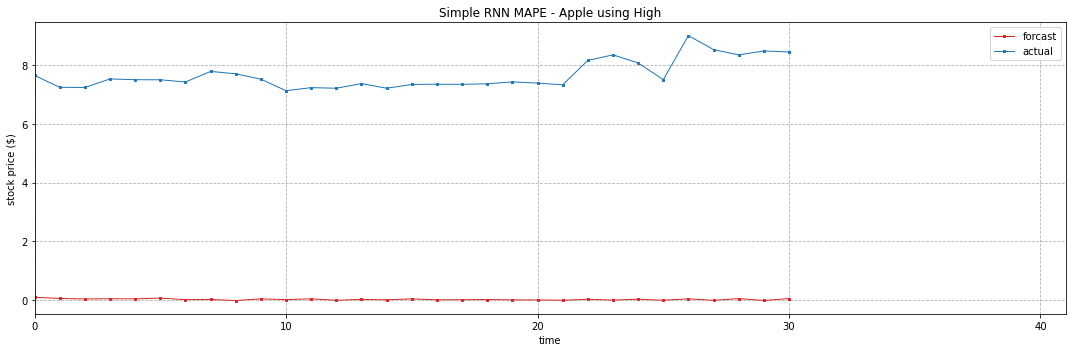

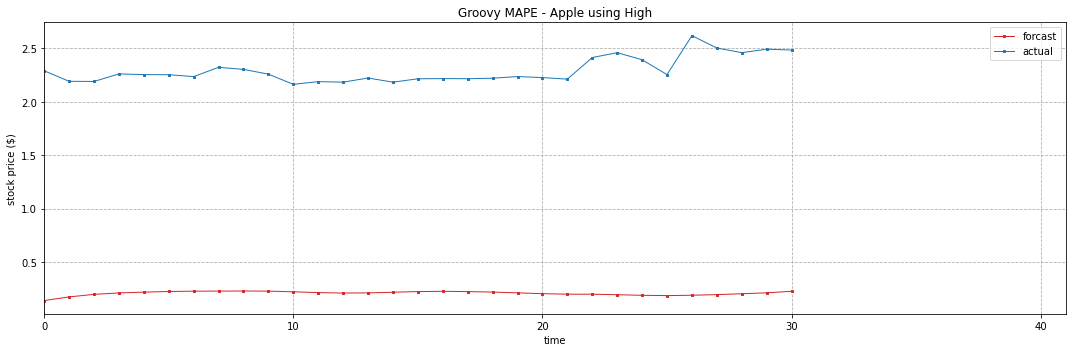

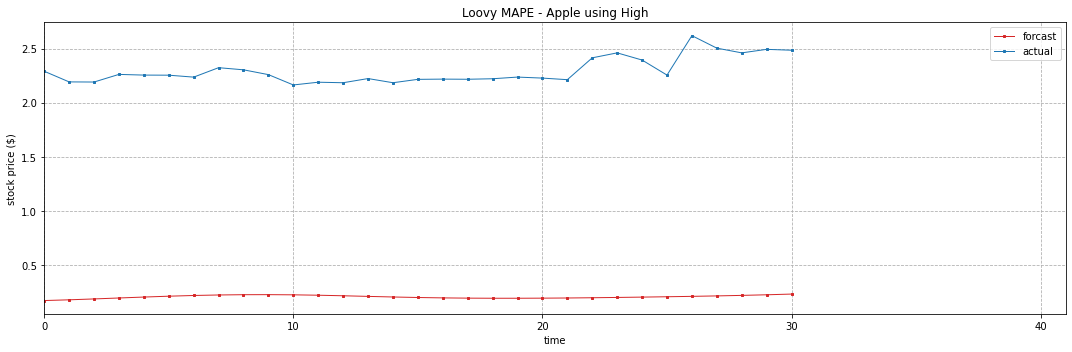

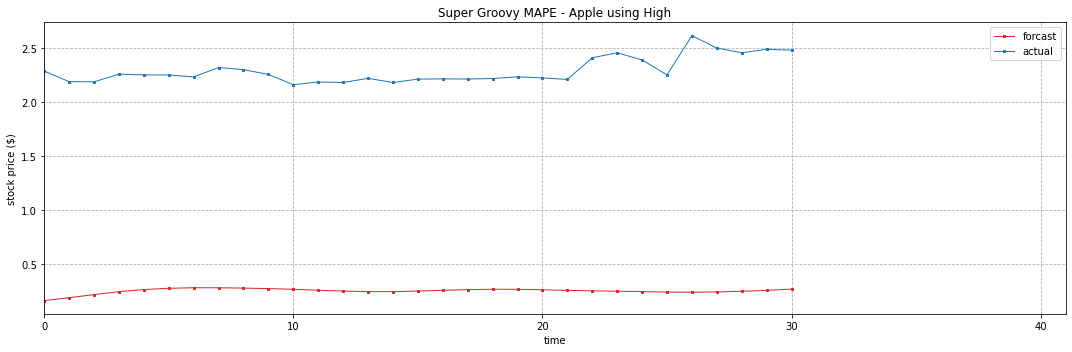

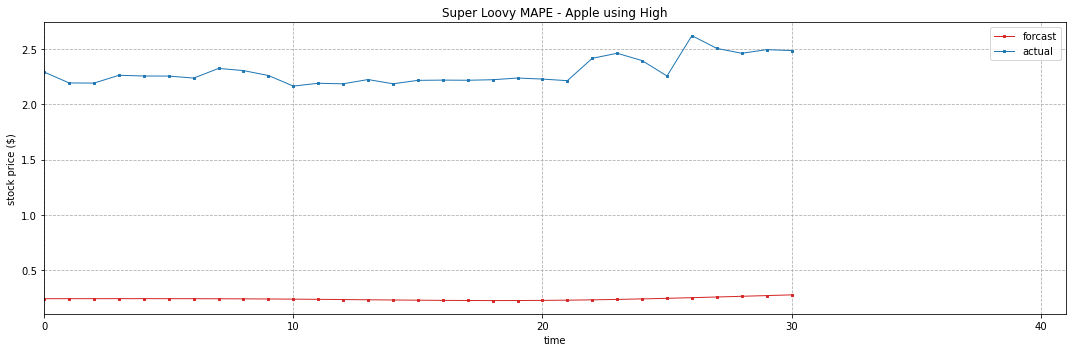

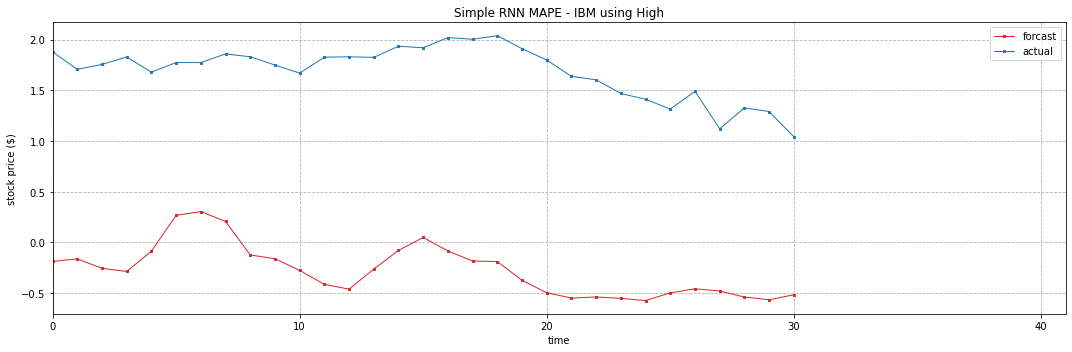

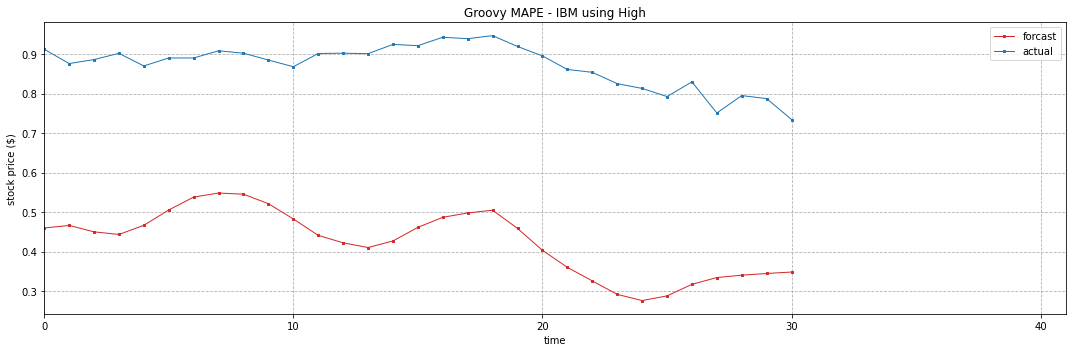

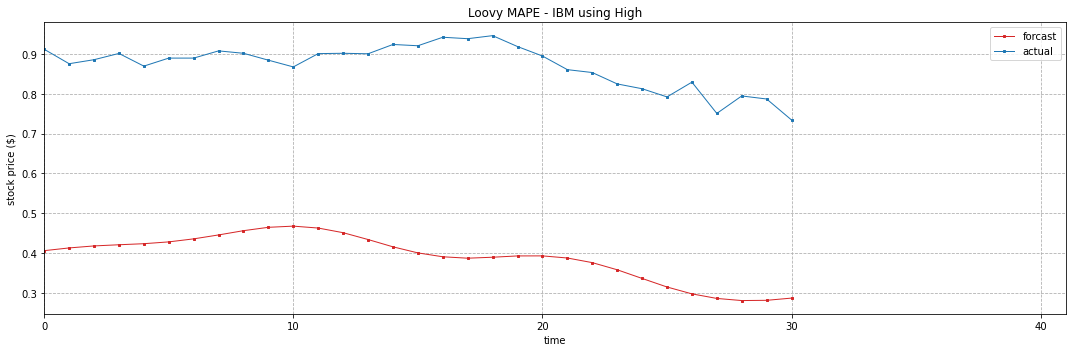

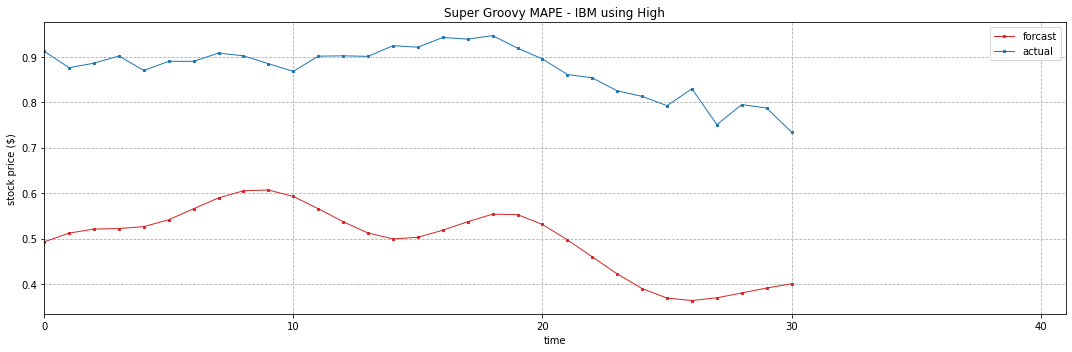

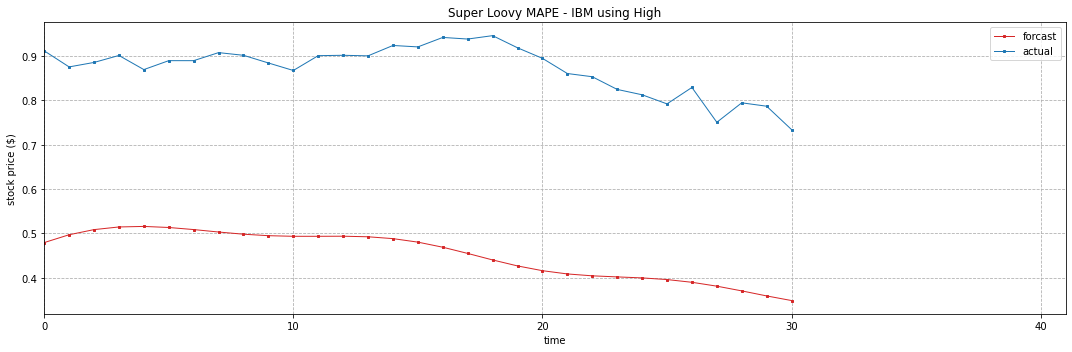

In [13]:
# Apple
print('Starting Simple RNN MAPE - Apple using High')
simple_rnn_apple, sr_scaler_apple = build_simple_rnn()
simple_rnn_apple, sr_y_preds, sr_test_data = train_predict_high(full_apple_train, full_apple_test, simple_rnn_apple, sr_scaler_apple, sr_epochs, sr_batch_size)
sr_diff = len(sr_test_data) - len(sr_y_preds)
plot_results(sr_y_preds, sr_test_data[sr_diff:], 'Simple RNN MAPE - Apple using High')

print('Starting Groovy RNN MAPE - Apple using High')
groovy_rnn_apple, g_scaler_apple = build_groovy()
groovy_rnn_apple, g_y_preds, g_test_data = train_predict_high(full_apple_train, full_apple_test, groovy_rnn_apple, g_scaler_apple, g_epochs, g_batch_size)
g_diff = len(g_test_data) - len(g_y_preds)
plot_results(g_y_preds, g_test_data[g_diff:], 'Groovy MAPE - Apple using High')

print('Starting Loovy RNN MAPE - Apple using High')
loovy_rnn_apple, l_scaler_apple = build_loovy()
loovy_rnn_apple, l_y_preds, l_test_data = train_predict_high(full_apple_train, full_apple_test, loovy_rnn_apple, l_scaler_apple, l_epochs, l_batch_size)
l_diff = len(l_test_data) - len(l_y_preds)
plot_results(l_y_preds, l_test_data[l_diff:], 'Loovy MAPE - Apple using High')

print('Starting Super Groovy RNN MAPE - Apple using High')
super_groovy_rnn_apple, sg_scaler_apple = build_super_groovy()
super_groovy_rnn_apple, sg_y_preds, sg_test_data = train_predict_high(full_apple_train, full_apple_test, super_groovy_rnn_apple, sg_scaler_apple, sg_epochs, sg_batch_size)
sg_diff = len(sg_test_data) - len(sg_y_preds)
plot_results(sg_y_preds, sg_test_data[sg_diff:], 'Super Groovy MAPE - Apple using High')

print('Starting Super Loovy RNN MAPE - Apple using High')
super_loovy_rnn_apple, sl_scaler_apple = build_super_loovy()
super_loovy_rnn_apple, sl_y_preds, sl_test_data = train_predict_high(full_apple_train, full_apple_test, super_loovy_rnn_apple, sl_scaler_apple, sl_epochs, sl_batch_size)
sl_diff = len(sl_test_data) - len(sl_y_preds)
plot_results(sl_y_preds, sl_test_data[sl_diff:], 'Super Loovy MAPE - Apple using High')

# IBM
print('Starting Simple RNN MAPE - IBM using High')
simple_rnn_ibm, sr_scaler_ibm = build_simple_rnn()
simple_rnn_ibm, sr_y_preds, sr_test_data = train_predict_high(full_ibm_train, full_ibm_test, simple_rnn_ibm, sr_scaler_ibm, sr_epochs, sr_batch_size)
sr_diff = len(sr_test_data) - len(sr_y_preds)
plot_results(sr_y_preds, sr_test_data[sr_diff:], 'Simple RNN MAPE - IBM using High')

print('Starting Groovy RNN MAPE - IBM using High')
groovy_rnn_ibm, g_scaler_ibm = build_groovy()
groovy_rnn_ibm, g_y_preds, g_test_data = train_predict_high(full_ibm_train, full_ibm_test, groovy_rnn_ibm, g_scaler_ibm, g_epochs, g_batch_size)
g_diff = len(g_test_data) - len(g_y_preds)
plot_results(g_y_preds, g_test_data[g_diff:], 'Groovy MAPE - IBM using High')

print('Starting Loovy RNN MAPE - IBM using High')
loovy_rnn_ibm, l_scaler_ibm = build_loovy()
loovy_rnn_ibm, l_y_preds, l_test_data = train_predict_high(full_ibm_train, full_ibm_test, loovy_rnn_ibm, l_scaler_ibm, l_epochs, l_batch_size)
l_diff = len(l_test_data) - len(l_y_preds)
plot_results(l_y_preds, l_test_data[l_diff:], 'Loovy MAPE - IBM using High')

print('Starting Super Groovy RNN MAPE - IBM using High')
super_groovy_rnn_ibm, sg_scaler_ibm = build_super_groovy()
super_groovy_rnn_ibm, sg_y_preds, sg_test_data = train_predict_high(full_ibm_train, full_ibm_test, super_groovy_rnn_ibm, sg_scaler_ibm, sg_epochs, sg_batch_size)
sg_diff = len(sg_test_data) - len(sg_y_preds)
plot_results(sg_y_preds, sg_test_data[sg_diff:], 'Super Groovy MAPE - IBM using High')

print('Starting Super Loovy RNN MAPE - IBM using High')
super_loovy_rnn_ibm, sl_scaler_ibm = build_super_loovy()
super_loovy_rnn_ibm, sl_y_preds, sl_test_data = train_predict_high(full_ibm_train, full_ibm_test, super_loovy_rnn_ibm, sl_scaler_ibm, sl_epochs, sl_batch_size)
sl_diff = len(sl_test_data) - len(sl_y_preds)
plot_results(sl_y_preds, sl_test_data[sl_diff:], 'Super Loovy MAPE - IBM using High')

In [14]:
# simple_rnn_fapple, sr_scaler_apple = build_simple_rnn()
# simple_rnn_fapple, y_preds, y_test = train_predict_fractionals(frac_apple_train, frac_apple_test, simple_rnn_fapple, sr_epochs, sr_batch_size)
# diff = len(test_data) - len(y_preds)
# plot_results(y_preds, y_test, 'Simple RNN MAPE - Apple using Fractionals')

# simple_rnn_fibm, sr_scaler_apple = build_simple_rnn()
# simple_rnn_fibm, y_preds, test_data = train_predict_fractionals('ibm', simple_rnn_fibm, sr_epochs, sr_batch_size)
# # diff = len(test_data) - len(y_preds)
# plot_results(y_preds, y_test, 'Simple RNN MAPE - IBM using Fractionals')

60
[[0.47928932]
 [0.49697813]
 [0.50855905]
 [0.51455283]
 [0.5157813 ]
 [0.51336646]
 [0.5086652 ]
 [0.50314426]
 [0.49820617]
 [0.49486667]
 [0.49346164]
 [0.4934691 ]
 [0.49365458]
 [0.4923952 ]
 [0.48821762]
 [0.48031285]
 [0.46881425]
 [0.4548112 ]
 [0.44009307]
 [0.4266056 ]
 [0.41585836]
 [0.4085183 ]
 [0.40425295]
 [0.40183046]
 [0.3995621 ]
 [0.3958412 ]
 [0.38967937]
 [0.3809347 ]
 [0.37026146]
 [0.3589013 ]
 [0.34844497]]


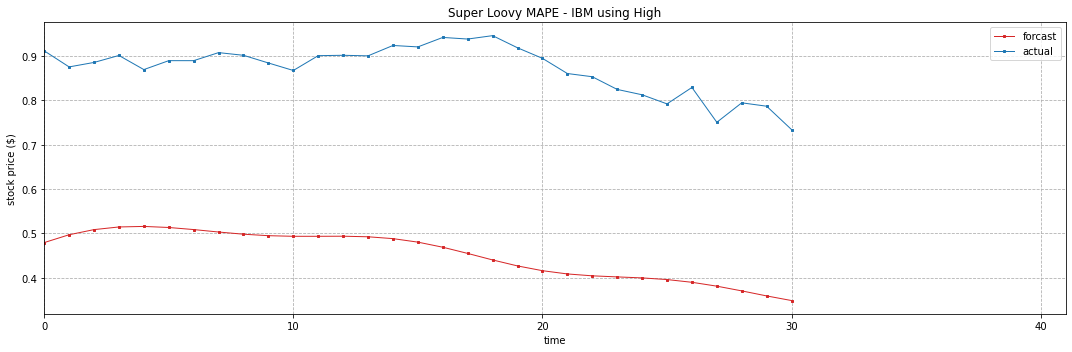

In [15]:
sl_diff = len(sl_test_data) - len(sl_y_preds)
print(sl_diff)
plot_results(sl_y_preds, sl_test_data[sl_diff:], 'Super Loovy MAPE - IBM using High')
print(sl_y_preds)
